## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.7]
redice_lr_patient = [5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0805 16:02:33.384451  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 16:02:33.386447  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 16:02:33.398415  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0805 16:02:33.586912  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0805 16:02:34.159757  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 16:02:34.177709  7104 deprecation_wrapper.py:119] From C:\Users\Rosa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 16:02:34.312350  7104 deprecation.py:323] From C:\Users\Rosa\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0,

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

Epoch 14/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2496 - acc: 0.5670 - val_loss: 1.4671 - val_acc: 0.4827
Epoch 15/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.2318 - acc: 0.5739 - val_loss: 1.4609 - val_acc: 0.4842
Epoch 16/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.2109 - acc: 0.5800 - val_loss: 1.4582 - val_acc: 0.4851
Epoch 17/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.1908 - acc: 0.5886 - val_loss: 1.4536 - val_acc: 0.4868
Epoch 18/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.1717 - acc: 0.5952 - val_loss: 1.4485 - val_acc: 0.4905
Epoch 19/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.1535 - acc: 0.6026 - val_loss: 1.4478 - val_acc: 0.4911
Epoch 20/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.1363 - acc: 0.6096 - val_loss: 1.4567 - val_acc: 0.4901
Epoch 21/25
50000/50000 [==

50000/50000 [==============================] - 8s 153us/step - loss: 2.2274 - acc: 0.2707 - val_loss: 2.1528 - val_acc: 0.3031
Epoch 2/25
50000/50000 [==============================] - 7s 133us/step - loss: 1.7632 - acc: 0.3863 - val_loss: 1.8280 - val_acc: 0.3706
Epoch 3/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.6356 - acc: 0.4271 - val_loss: 1.7054 - val_acc: 0.4056
Epoch 4/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5618 - acc: 0.4516 - val_loss: 1.6463 - val_acc: 0.4232
Epoch 5/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.5084 - acc: 0.4721 - val_loss: 1.6062 - val_acc: 0.4326
Epoch 6/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4661 - acc: 0.4870 - val_loss: 1.5667 - val_acc: 0.4462
Epoch 7/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4298 - acc: 0.4999 - val_loss: 1.5457 - val_acc: 0.4551
Epoch 8/25
50000/50000 [=====================


Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 24/25
50000/50000 [==============================] - 7s 140us/step - loss: 0.3386 - acc: 0.9076 - val_loss: 1.6936 - val_acc: 0.5144
Epoch 25/25
50000/50000 [==============================] - 7s 135us/step - loss: 0.3118 - acc: 0.9194 - val_loss: 1.6746 - val_acc: 0.5179
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)              

50000/50000 [==============================] - 8s 154us/step - loss: 1.0527 - acc: 0.6364 - val_loss: 1.4369 - val_acc: 0.5039
Epoch 11/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.0200 - acc: 0.6477 - val_loss: 1.4343 - val_acc: 0.4989
Epoch 12/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.9887 - acc: 0.6593 - val_loss: 1.4535 - val_acc: 0.4871
Epoch 13/25
50000/50000 [==============================] - 8s 158us/step - loss: 0.9610 - acc: 0.6706 - val_loss: 1.4217 - val_acc: 0.4986
Epoch 14/25
50000/50000 [==============================] - 8s 155us/step - loss: 0.9296 - acc: 0.6832 - val_loss: 1.4239 - val_acc: 0.5057

Epoch 00014: ReduceLROnPlateau reducing learning rate to 8.750000415602699e-05.
Epoch 15/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.8874 - acc: 0.7012 - val_loss: 1.4052 - val_acc: 0.5102
Epoch 16/25
50000/50000 [==============================] - 8s 165us/step - loss: 0.8676 - acc: 0.

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.8300 - acc: 0.3667 - val_loss: 2.3796 - val_acc: 0.2803
Epoch 2/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.5332 - acc: 0.4571 - val_loss: 3.3954 - val_acc: 0.2172
Epoch 3/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.4199 - acc: 0.4976 - val_loss: 2.0697 - val_acc: 0.3359
Epoch 4/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.3384 - acc: 0.5279 - val_loss: 1.9647 - val_acc: 0.3465
Epoch 5/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.2765 - acc: 0.5482 - val_loss: 2.2819 - val_acc: 0.2939
Epoch 6/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.2176 - acc: 0.5696 - val_loss: 1.8686 - val_acc: 0.3587
Epoch 7/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.1747 - acc: 0.5839 - val_loss: 1.8448 - 

Epoch 23/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.7368 - acc: 0.7559 - val_loss: 1.6034 - val_acc: 0.4788
Epoch 24/25
50000/50000 [==============================] - 6s 123us/step - loss: 0.7142 - acc: 0.7625 - val_loss: 1.9027 - val_acc: 0.4400

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 25/25
50000/50000 [==============================] - 6s 121us/step - loss: 0.6258 - acc: 0.8038 - val_loss: 1.6090 - val_acc: 0.4849
Numbers of exp: 10, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)       

50000/50000 [==============================] - 6s 126us/step - loss: 1.3784 - acc: 0.5201 - val_loss: 1.5926 - val_acc: 0.4483
Epoch 9/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.3468 - acc: 0.5315 - val_loss: 1.6177 - val_acc: 0.4350
Epoch 10/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.3160 - acc: 0.5437 - val_loss: 1.5557 - val_acc: 0.4534
Epoch 11/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.2881 - acc: 0.5528 - val_loss: 1.5778 - val_acc: 0.4454
Epoch 12/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.2621 - acc: 0.5614 - val_loss: 1.5171 - val_acc: 0.4629
Epoch 13/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.2382 - acc: 0.5718 - val_loss: 1.5158 - val_acc: 0.4675
Epoch 14/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.2126 - acc: 0.5820 - val_loss: 1.5295 - val_acc: 0.4650
Epoch 15/25
50000/50000 [===============

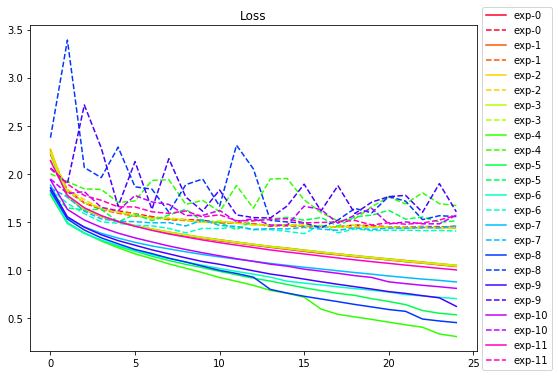

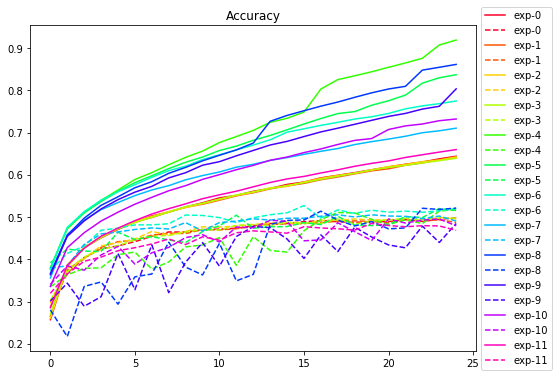

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()